<a href="https://colab.research.google.com/github/Ptuancuong/TH1-Train.csv/blob/main/THUCHANH02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
a = (2251262584%15+1)
a

5

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
df = pd.read_csv('/content/monthly_csv.csv')
df.head(10)


,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292
5,GISTEMP,2016-10-06,0.8900
6,GCAG,2016-09-06,0.8767
7,GISTEMP,2016-09-06,0.8700
8,GCAG,2016-08-06,0.8998
9,GISTEMP,2016-08-06,0.9800


In [4]:
!pip install hmmlearn


In [5]:
!pip install GPy

In [6]:
import hmmlearn
print(hmmlearn.__version__)

0.3.3


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import GPy
from datetime import datetime
from io import StringIO

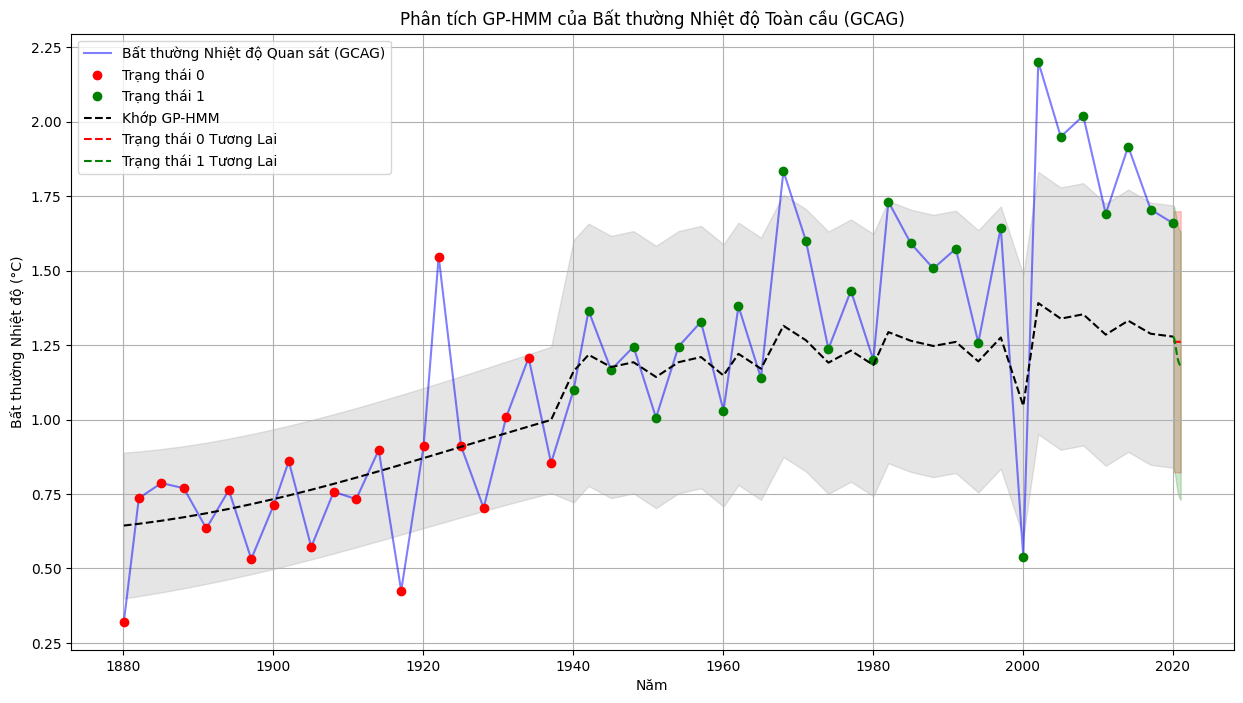

In [9]:
# Tạo dữ liệu giả lập cho GCAG với 50 điểm
def generate_sample_data():
    years = np.linspace(1880, 2020, 50)
    temps = np.random.normal(0.5, 0.3, 50) + 0.01 * (years - 1880)  # Xu hướng tăng nhẹ
    data = pd.DataFrame({
        'Source': ['GCAG'] * 50,
        'Date': [f"{int(y)}-01-06" for y in years],
        'Mean': temps
    })
    return data.to_csv(index=False)

# Tải và tiền xử lý dữ liệu CSV, chỉ lấy nguồn GCAG
def load_and_preprocess_data(csv_data, selected_source='GCAG'):
    df = pd.read_csv(StringIO(csv_data))
    df = df[df['Source'] == selected_source]
    if df.empty:
        raise ValueError("Dữ liệu rỗng sau khi lọc theo nguồn!")
    df['Date'] = pd.to_datetime(df['Date'])
    df['YearMonth'] = df['Date'].apply(lambda x: x.year + x.month / 12.0)
    df = df.sort_values('Date')
    time = df['YearMonth'].values
    temps = df['Mean'].values
    if len(temps) < 10:  # Đảm bảo đủ dữ liệu
        raise ValueError("Số điểm dữ liệu quá ít để huấn luyện mô hình!")
    temp_mean = np.mean(temps)
    temp_std = np.std(temps)
    temps_normalized = (temps - temp_mean) / temp_std
    return time, temps, temps_normalized, temp_mean, temp_std

# Huấn luyện HMM để xác định các trạng thái
def fit_hmm(data, n_states=3):
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    model.fit(data.reshape(-1, 1))
    states = model.predict(data.reshape(-1, 1))
    return model, states

# Huấn luyện GP cho mỗi trạng thái
def fit_gp_per_state(time, data, states, n_states):
    gps = []
    for state in range(n_states):
        state_mask = states == state
        state_time = time[state_mask].reshape(-1, 1)
        state_data = data[state_mask].reshape(-1, 1)
        if len(state_data) == 0:
            continue  # Bỏ qua nếu không có dữ liệu cho trạng thái
        kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.White(input_dim=1)
        gp_model = GPy.models.GPRegression(state_time, state_data, kernel)
        gp_model.optimize()
        gps.append(gp_model)
    return gps

# Dự đoán với GP-HMM
def predict_gp_hmm(time, data, states, gps, future_steps=12):
    predictions = np.zeros_like(data)
    pred_variances = np.zeros_like(data)
    future_time = np.linspace(time[-1], time[-1] + future_steps / 12.0, future_steps)
    future_preds = []
    future_vars = []
    for state in np.unique(states):
        state_mask = states == state
        state_time = time[state_mask].reshape(-1, 1)
        if len(state_time) == 0:
            continue
        gp = gps[state]
        pred, var = gp.predict(state_time)
        predictions[state_mask] = pred.flatten()
        pred_variances[state_mask] = var.flatten()
        future_pred, future_var = gp.predict(future_time.reshape(-1, 1))
        future_preds.append(future_pred)
        future_vars.append(future_var)
    return predictions, pred_variances, future_time, future_preds, future_vars


def plot_results(time, temps, temps_normalized, states, predictions, pred_variances, future_time, future_preds, future_vars, temp_mean, temp_std):
    plt.figure(figsize=(15, 8))
    plt.plot(time, temps, 'b-', label='Bất thường Nhiệt độ Quan sát (GCAG)', alpha=0.5)
    colors = ['r', 'g', 'purple']
    for state in np.unique(states):
        state_mask = states == state
        plt.plot(time[state_mask], temps[state_mask], 'o', color=colors[state], label=f'Trạng thái {state}')
    predictions_denorm = predictions * temp_std + temp_mean
    variances_denorm = pred_variances * (temp_std ** 2)
    plt.plot(time, predictions_denorm, 'k--', label='Khớp GP-HMM')
    plt.fill_between(time, predictions_denorm - np.sqrt(variances_denorm),
                     predictions_denorm + np.sqrt(variances_denorm), alpha=0.2, color='gray')
    for state, (f_pred, f_var) in enumerate(zip(future_preds, future_vars)):
        f_pred_denorm = f_pred * temp_std + temp_mean
        f_var_denorm = f_var * (temp_std ** 2)
        plt.plot(future_time, f_pred_denorm, '--', color=colors[state], label=f'Trạng thái {state} Tương Lai')
        plt.fill_between(future_time, f_pred_denorm.flatten() - np.sqrt(f_var_denorm.flatten()),
                         f_pred_denorm.flatten() + np.sqrt(f_var_denorm.flatten()), alpha=0.2, color=colors[state])
    plt.xlabel('Năm')
    plt.ylabel('Bất thường Nhiệt độ (°C)')
    plt.title('Phân tích GP-HMM của Bất thường Nhiệt độ Toàn cầu (GCAG)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Hàm chính
def main(csv_data):
    time, temps, temps_normalized, temp_mean, temp_std = load_and_preprocess_data(csv_data, selected_source='GCAG')
    n_states = 2  # Giảm số trạng thái để phù hợp với dữ liệu giả
    hmm_model, states = fit_hmm(temps_normalized, n_states)
    gps = fit_gp_per_state(time, temps_normalized, states, n_states)
    predictions, pred_variances, future_time, future_preds, future_vars = predict_gp_hmm(
        time, temps_normalized, states, gps)
    plot_results(time, temps, temps_normalized, states, predictions, pred_variances,
                 future_time, future_preds, future_vars, temp_mean, temp_std)


csv_data = generate_sample_data()

if __name__ == "__main__":
    main(csv_data)